<a href="https://colab.research.google.com/github/fouzanhaider/Network-Traffic-Scanner/blob/main/network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

def load_preprocess_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    x_train_reduced = x_train[:20000]
    y_train_reduced = y_train[:20000]
    x_test_reduced = x_test[:4000]
    y_test_reduced = y_test[:4000]

    return x_train_reduced, y_train_reduced, x_test_reduced, y_test_reduced

def load_kdd99():
    kdd99_df = pd.read_csv('/content/kddcup99_csv.csv')
    X_kdd99 = kdd99_df.iloc[:, :-1]
    y_kdd99 = kdd99_df.iloc[:, -1]

    if y_kdd99.dtype == 'O':
        label_encoder = LabelEncoder()
        y_kdd99 = label_encoder.fit_transform(y_kdd99)

    categorical_features = X_kdd99.select_dtypes(include=['object']).columns
    X_kdd99 = pd.get_dummies(X_kdd99, columns=categorical_features)

    return X_kdd99.values, y_kdd99

# Load and preprocess data
x_train_mnist_reduced, y_train_mnist, x_test_mnist_reduced, y_test_mnist = load_preprocess_mnist()
X_kdd99, y_kdd99 = load_kdd99()

# Flatten MNIST data
x_train_mnist_flat = x_train_mnist_reduced.reshape(len(x_train_mnist_reduced), -1)
x_test_mnist_flat = x_test_mnist_reduced.reshape(len(x_test_mnist_reduced), -1)

# Perform KPCA on MNIST data
num_features_kdd99 = X_kdd99.shape[1]
kpca = KernelPCA(n_components=num_features_kdd99, kernel='rbf')
x_train_mnist_kpca = kpca.fit_transform(x_train_mnist_flat)
x_test_mnist_kpca = kpca.transform(x_test_mnist_flat)

# Combine datasets
quarter_length_kdd99 = len(X_kdd99) // 4
quarter_length_mnist = len(x_train_mnist_kpca) // 4

X_combined = np.concatenate((X_kdd99[:quarter_length_kdd99], x_train_mnist_kpca[:quarter_length_mnist]), axis=0)
y_combined = np.concatenate((y_kdd99[:quarter_length_kdd99], y_train_mnist[:quarter_length_mnist]))

# Split combined data
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Ensure labels are within range
y_train_combined = y_train_combined % 20
y_test_combined = y_test_combined % 20

# CNN model parameters
num_filters = 32  # Increased the number of filters
kernel_size = 5
pool_size = 2
dense_units = 64  # Increased the number of dense units
dropout_rate = 0.5
epochs = 10  # Increased the number of epochs
batch_size = 128

# Reshape data for CNN
input_shape = (num_features_kdd99, 1)
X_train_cnn = np.expand_dims(X_train_combined, axis=-1).astype('float32')
X_test_cnn = np.expand_dims(X_test_combined, axis=-1).astype('float32')
y_train_combined = y_train_combined.astype('int')
y_test_combined = y_test_combined.astype('int')
num_classes = len(np.unique(y_combined))

# Custom CNN Model architecture
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same', input_shape=input_shape))
cnn_model.add(MaxPooling1D(pool_size=pool_size, padding='same'))
cnn_model.add(Conv1D(filters=num_filters//2, kernel_size=kernel_size, activation='relu', padding='same'))
cnn_model.add(MaxPooling1D(pool_size=pool_size, padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(dense_units, activation='relu'))
cnn_model.add(Dropout(dropout_rate))
cnn_model.add(Dense(num_classes, activation='softmax'))

# Compile the model with a customized learning rate
adam_optimizer = Adam(learning_rate=0.0005)  # Decreased the learning rate
cnn_model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_cnn, y_train_combined, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# Evaluate the model
accuracy = cnn_model.evaluate(X_test_cnn, y_test_combined, verbose=0)[1]
print(f'Accuracy with KPCA: {accuracy:.2f}')

# Predict probabilities for each class
y_pred_probabilities = cnn_model.predict(X_test_cnn)

# Get predicted classes
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_combined, y_pred, average='weighted')
recall = recall_score(y_test_combined, y_pred, average='weighted')
f1 = f1_score(y_test_combined, y_pred, average='weighted')

print("Classification Report:")
print(classification_report(y_test_combined, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test_combined, y_pred)
print(conf_matrix)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
643/643 [==============================] - 12s 16ms/step - loss: 16.7535 - accuracy: 0.8798 - val_loss: 7.0502 - val_accuracy: 0.9442
Epoch 2/10
643/643 [==============================] - 12s 19ms/step - loss: 6.0326 - accuracy: 0.9265 - val_loss: 0.6381 - val_accuracy: 0.9487
Epoch 3/10
643/643 [==============================] - 12s 18ms/step - loss: 1.5109 - accuracy: 0.9369 - val_loss: 0.8646 - val_accuracy: 0.9546
Epoch 4/10
643/643 [==============================] - 12s 18ms/step - loss: 0.5338 - accuracy: 0.9424 - val_loss: 0.3072 - val_accuracy: 0.9538
Epoch 5/10
643/643 [==============================] - 13s 20ms/step - loss: 0.3660 - accuracy: 0.9426 - val_loss: 0.1836 - val_accuracy: 0.9552
Epoch 6/10
643/643 [==============================] - 11s 17ms/step - loss: 0.2635 - accuracy: 0.9450 - val_loss: 0.1643 - val_accuracy: 0.9558
Epoch 7/10
643/643 [==============================] - 11s 17ms/step - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical

# Define ontology rules
ontology_rules = {
    "HighRisk": lambda features: features["num_failed_logins"] > 0.8 and features["dst_bytes"] < 0.2,
    "LowRisk": lambda features: features["dst_host_srv_diff_host_rate"] > 0.5,
    "SuspiciousPattern": lambda features: features["dst_bytes"] > 0.5 and features["dst_host_diff_srv_rate"] < 0.2,
    "KnownAttack": lambda features: features.get("srv_serror_rate", 0) == 1,
    "Normal": lambda features: True
}

def load_kdd99():
    # Load KDD Cup 99 dataset
    kdd99_df = pd.read_csv('/content/kddcup99_csv.csv')

    # Handling missing values
    kdd99_df.fillna(0, inplace=True)

    X_kdd99 = kdd99_df.iloc[:, :-1]
    y_kdd99 = kdd99_df.iloc[:, -1]

    # Encode categorical labels
    if y_kdd99.dtype == 'O':
        label_encoder = LabelEncoder()
        y_kdd99 = label_encoder.fit_transform(y_kdd99)

    return X_kdd99, y_kdd99

def apply_ontology_rules(features, ontology_rules):
    # Apply ontology rules to categorize features
    category = "Normal"
    if ontology_rules["KnownAttack"](features):
        category = "Attack"
    elif not ontology_rules["KnownAttack"](features):
        for rule, condition in ontology_rules.items():
            if rule != "KnownAttack" and condition(features):
                category = rule
                break
    return category

# Load KDD Cup 99 dataset
X_kdd99, y_kdd99 = load_kdd99()

# Apply ontology rules
attack_categories = [apply_ontology_rules(row, ontology_rules) for _, row in X_kdd99.iterrows()]

# Convert attack categories to numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(attack_categories)

# Convert labels to one-hot encoded format
y_encoded = to_categorical(y_encoded)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_kdd99, y_encoded, test_size=0.2, random_state=42)

# Handle categorical features: One-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=['protocol_type', 'service', 'flag'])
X_test_encoded = pd.get_dummies(X_test, columns=['protocol_type', 'service', 'flag'])

# Align feature names in the test set with training set
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Reshape input data for CNN
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1, 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1, 1)

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 1), activation='relu', input_shape=(X_train_cnn.shape[1], 1, 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of categories in output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Reverse transform encoded labels to original attack categories
predicted_labels_encoded = model.predict(X_test_cnn)
predicted_labels = label_encoder.inverse_transform([np.argmax(label) for label in predicted_labels_encoded])

# Count occurrences of each attack category
attack_counts = {}
for label in predicted_labels:
    attack_counts[label] = attack_counts.get(label, 0) + 1

# Print attack categories and their counts
for attack, count in attack_counts.items():
    print(f"Attack: {attack}, Count: {count}")

from sklearn.metrics import classification_report, confusion_matrix, precision_score

# Predict probabilities for each class
y_pred_prob = model.predict(X_test_cnn)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded y_test back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision
precision = precision_score(y_test_labels, y_pred, average='weighted')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Generate classification report
class_report = classification_report(y_test_labels, y_pred)

print("Precision:", precision)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Epoch 1/5
11116/11116 [==============================] - 59s 5ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0139 - val_accuracy: 0.9949
Epoch 2/5
11116/11116 [==============================] - 61s 5ms/step - loss: 0.0154 - accuracy: 0.9950 - val_loss: 0.0123 - val_accuracy: 0.9953
Epoch 3/5
11116/11116 [==============================] - 60s 5ms/step - loss: 0.0130 - accuracy: 0.9952 - val_loss: 0.0121 - val_accuracy: 0.9955
Epoch 4/5
11116/11116 [==============================] - 57s 5ms/step - loss: 0.0124 - accuracy: 0.9952 - val_loss: 0.0112 - val_accuracy: 0.9957
Epoch 5/5
3088/3088 [==============================] - 8s 3ms/step - loss: 0.0127 - accuracy: 0.9952
Test Loss: 0.012741146609187126, Test Accuracy: 0.9951621294021606
3088/3088 [==============================] - 6s 2ms/step
Attack: Normal, Count: 65042
Attack: Attack, Count: 17394
Attack: SuspiciousPattern, Count: 16227
Attack: LowRisk, Count: 141
3088/3088 [==============================] - 6s 2ms/step
Precisio

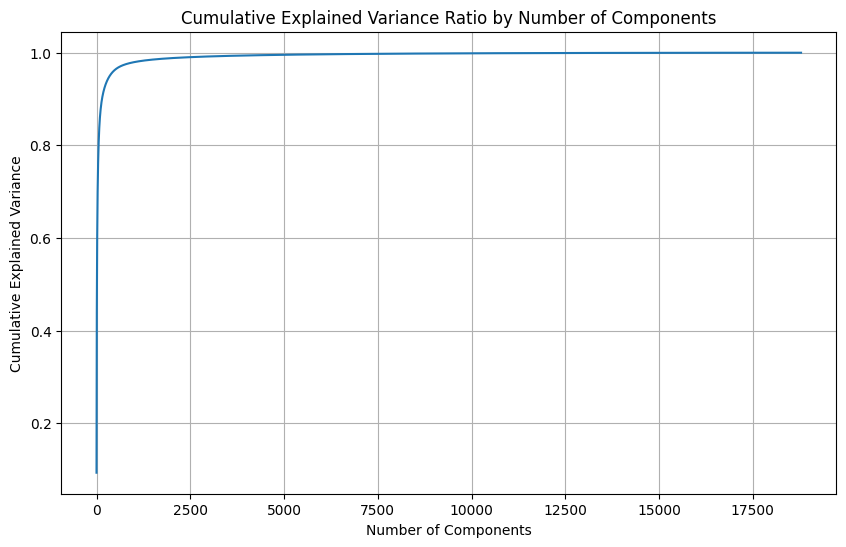

In [ ]:
import matplotlib.pyplot as plt

# Fit KPCA on MNIST data
kpca = KernelPCA(kernel='rbf')
x_train_mnist_kpca = kpca.fit_transform(x_train_mnist_flat)

# Calculate explained variance ratio manually
explained_variance_ratio = np.var(x_train_mnist_kpca, axis=0) / np.sum(np.var(x_train_mnist_kpca, axis=0))

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Ratio by Number of Components')
plt.grid(True)
plt.show()
